In [1]:
import os
import pandapower as pp
import polars as pl
from polars import col as c

# from pipelines.dig_a_plan_slack_v import DigAPlan

from data_display.grid_plotting import plot_grid_from_pandapower
from data_display.output_processing import compare_dig_a_plan_with_pandapower
from data_connector import pandapower_to_dig_a_plan_schema


from pipelines.dig_a_plan_d_model import DigAPlan
import matplotlib.pyplot as plt

os.chdir(os.getcwd().replace("/src", ""))
os.environ['GRB_LICENSE_FILE'] = os.environ["HOME"] + "/gurobi_license/gurobi.lic"


In [2]:
LOAD_FACTOR  = 2.5
net = pp.from_pickle(".cache/input_data/mv_example.p")

net["load"]["p_mw"] = net["load"]["p_mw"]*LOAD_FACTOR
net["load"]["q_mvar"] = net["load"]["q_mvar"]*LOAD_FACTOR
# net["trafo"]["vn_hv_kv"] = [110., 110.]
# # net["trafo"]["vn_lv_kv"] = [17.8, 21.8]
# net["trafo"]["vn_lv_kv"] = [18.5, 21.5]

# line_list= [6, 9, 11, 13, 16]

# net["line"].loc[:, "max_i_ka"] = 1e3

In [ ]:
grid_data = pandapower_to_dig_a_plan_schema(net=net)

dig_a_plan: DigAPlan = DigAPlan(
    verbose= False, big_m = 1e4, penalty_cost = 1e1
)

dig_a_plan.add_grid_data(**grid_data)
dig_a_plan.solve_models_pipeline(max_iters = 200)

Master obj: 0, Slave obj: 0 and Gap: 1e6:   0%|          | 0/200 [00:00<?, ?it/s]2025-06-19 14:12:16 B01BPC06 pipelines.dig_a_plan_d_model[1444955] WARNING 
Master model did not converge: infeasibleOrUnbounded


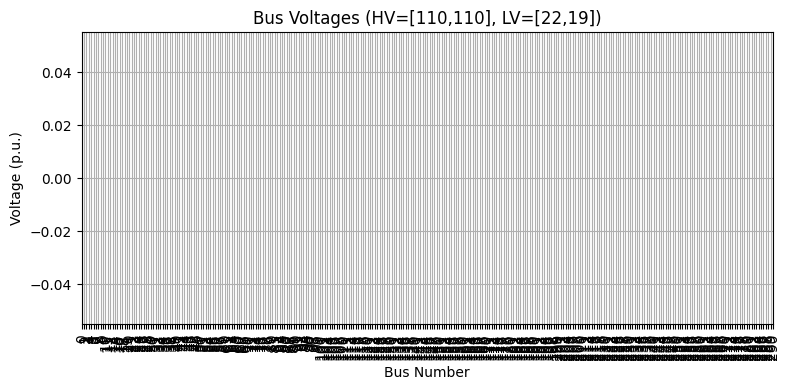

In [4]:
# Extract voltages
v_df: pl.DataFrame = dig_a_plan.extract_node_voltage()    # Polars DF with node_id & v_pu
v_pd = v_df.to_pandas().sort_values("node_id")    # convert to pandas & sort

# Plot
plt.figure(figsize=(8,4))
plt.plot(
    v_pd["node_id"],
    v_pd["v_pu"],
    marker='o',
    linestyle='-'
)
plt.xlabel("Bus Number")
plt.ylabel("Voltage (p.u.)")
plt.title("Bus Voltages (HV=[110,110], LV=[22,19])")
plt.xticks(v_pd["node_id"], rotation=90)   # show every bus ID on the x-axis
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
compare_dig_a_plan_with_pandapower(dig_a_plan=dig_a_plan, net=net)
plot_grid_from_pandapower(net=net)

LoadflowNotConverged: Power Flow nr did not converge after 10 iterations!